In [1]:
import torch

import pandas as pd
import numpy as np
import cv2

import os
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.io import read_image
import torchvision.models as models
import torch.nn as nn

import yaml


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
#Load the configuration file

with open('../config_train_DR.yaml') as file:
    yaml_data = yaml.safe_load(file)

## Explore Data and Build Dataset

In [10]:
ROOT_PATH = yaml_data['dataset']['root_path']
os.listdir(os.path.join(ROOT_PATH, 'final_train', 'train'))[0:10]

['18329_right.jpeg',
 '24944_left.jpeg',
 '41031_right.jpeg',
 '4484_right.jpeg',
 '38136_right.jpeg',
 '39671_left.jpeg',
 '6561_left.jpeg',
 '19878_left.jpeg',
 '10061_left.jpeg',
 '19056_left.jpeg']

In [11]:
# train_labels_df = pd.read_csv(os.path.join(ROOT_PATH, 'trainLabels.csv'))
# train_labels_df['image'] = train_labels_df['image'].apply(lambda x: str(ROOT_PATH+'final_train/train/'+x+'.jpeg'))
# train_labels_df.head()

train_labels_df = pd.read_csv(yaml_data['train']['train_df_path'])
print(len(train_labels_df))
train_labels_df.head()

35126


,image,level,quality
0,/home/raman/MLP-RIQA/data/diabetic-retinopathy...,0,Usable
1,/home/raman/MLP-RIQA/data/diabetic-retinopathy...,0,Reject
2,/home/raman/MLP-RIQA/data/diabetic-retinopathy...,0,Good
3,/home/raman/MLP-RIQA/data/diabetic-retinopathy...,0,Good
4,/home/raman/MLP-RIQA/data/diabetic-retinopathy...,1,Good


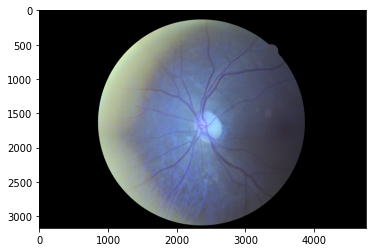

In [5]:
img = cv2.imread(train_labels_df['image'][0])
plt.imshow(img, )

In [12]:
class RetinopathyDataset(Dataset):
    def __init__(self, train_df, transforms=None, threshold=None, categorical_partitition=True, cat_labels_to_include=['Good', 'Usable', 'Reject']):
        self.train_df = train_df
        self.transforms = transforms
        self.threshold = threshold
        self.categorical_partitition = categorical_partitition
        self.cat_labels = cat_labels_to_include

        if(self.categorical_partitition == True):
            #This means we have categorical labels for image quality ['Good', 'Usable', 'Bad'] instead of continuous labels
            self.threshold = None   #Continuous labels threshold does not matter in this case

            if(self.cat_labels == None):
                raise AssertionError("Categorical labels should be provided when 'categorical partition' is set to True")
            else:
                self.train_df = self.train_df[self.train_df['quality'].isin(self.cat_labels).reset_index(drop=True)]

        else:
            if(self.threshold == None):
                raise AssertionError("Threshold should be provided when 'categorical_partitition' is false.")
                
            self.train_df = self.train_df[self.train_df['score']>=self.threshold].reset_index(drop=True)

    def __len__(self):
        return len(self.train_df)

    def __getitem__(self, idx):
            
        print("Index: ", idx)
        print("Image: ", self.train_df['image'][idx])
        print("Label: ", self.train_df['level'][idx])
        
        image = read_image(self.train_df['image'][idx])
        label = self.train_df['level'][idx]

        if(self.transforms):
            image = self.transforms(image)

        return image, label



train_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224,224)),
    T.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dummy_dataset = RetinopathyDataset(train_labels_df, train_transform)
img, label = next(iter(dummy_dataset))

print(img.size())


Index:  0
Image:  /home/raman/MLP-RIQA/data/diabetic-retinopathy-detection/final_train/train/10_left.jpeg
Label:  0
torch.Size([3, 224, 224])


In [ ]:
dataset = RetinopathyDataset(train_labels_df,train_transform)
                    
loader = DataLoader(dataset, batch_size=64)
for batch in loader:
    x, y = batch
    print(x.shape, y.shape)
    break

## Build Model

We would need to train a model each time with the new dataset

In [ ]:
PRETRAINED = True
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
NUM_EPOCHS = 2
NUM_CLASSES = len(train_labels_df['level'].unique())

In [ ]:
model = models.resnet34(pretrained=PRETRAINED).to(device)
num_filters = model.fc.in_features

model.fc = nn.Linear(num_filters, NUM_CLASSES)

model.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
loss_criterion = torch.nn.CrossEntropyLoss()
train_dataloader = DataLoader(dataset=RetinopathyDataset(train_labels_df, transforms=train_transform), 
                              batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(NUM_EPOCHS):
    for data, target in tqdm(train_dataloader):
        data = data.to(device=device)
        target = target.to(device=device)
        
        score = model(data)
        optimizer.zero_grad()
        
        loss = loss_criterion(score, target)
        loss.backward()
        
        optimizer.step()
    
    print(f"for epoch {epoch}, loss : {loss}")


## RIQA Labels

In [14]:
train_labels_df2= pd.read_csv(yaml_data['dataset']['RIQA_train_labels'])
test_labels_df2 = pd.read_csv(yaml_data['dataset']['RIQA_test_labels'])
train_labels_df2.head()

,Unnamed: 0,name,quality
0,0,41059_left.jpeg,Good
1,1,23657_right.jpeg,Usable
2,2,37478_right.jpeg,Good
3,3,25656_right.jpeg,Good
4,4,4764_right.jpeg,Usable


In [15]:
train_labels_df2.quality.value_counts()

Good      16494
Usable    12710
Reject     5922
Name: quality, dtype: int64

In [16]:
test_labels_df2.quality.value_counts()

Good      25174
Usable    19243
Reject     9159
Name: quality, dtype: int64

## Creating final dataset

In [17]:
df_diabetic_labels = pd.read_csv(os.path.join(ROOT_PATH, 'trainLabels.csv'))
df_diabetic_labels_test = pd.read_csv(os.path.join(ROOT_PATH, 'testLabels.csv'))

df_riqa_labels = pd.read_csv(yaml_data['dataset']['RIQA_train_labels'])
df_riqa_labels_test = pd.read_csv(yaml_data['dataset']['RIQA_test_labels'])

df_riqa_labels.rename({'name':'image'}, inplace=True, axis=1)
df_riqa_labels.drop(['Unnamed: 0'], axis=1, inplace=True)
df_riqa_labels_test.rename({'name':'image'}, inplace=True, axis=1)
df_riqa_labels_test.drop(['Unnamed: 0'], axis=1, inplace=True)

df_diabetic_labels['image'] = df_diabetic_labels['image'].apply(lambda x: x+'.jpeg')
df_diabetic_labels_test['image'] = df_diabetic_labels_test['image'].apply(lambda x: x+'.jpeg')

In [18]:
#Both dataframes have the same columns now.

df_diabetic_labels.columns, df_riqa_labels.columns, df_riqa_labels_test.columns

(Index(['image', 'level'], dtype='object'),
 Index(['image', 'quality'], dtype='object'),
 Index(['image', 'quality'], dtype='object'))

In [13]:
df_diabetic_labels['image'][0:5], df_riqa_labels['image'][0:5], df_riqa_labels_test['image'][0:5]

(0     10_left.jpeg
 1    10_right.jpeg
 2     13_left.jpeg
 3    13_right.jpeg
 4     15_left.jpeg
 Name: image, dtype: object,
 0     41059_left.jpeg
 1    23657_right.jpeg
 2    37478_right.jpeg
 3    25656_right.jpeg
 4     4764_right.jpeg
 Name: image, dtype: object,
 0     37398_left.jpeg
 1     23632_left.jpeg
 2    22845_right.jpeg
 3       809_left.jpeg
 4     40461_left.jpeg
 Name: image, dtype: object)

In [19]:
df_diabetic_labels_test.head()

,image,level
0,1_left.jpeg,0
1,1_right.jpeg,0
2,2_left.jpeg,0
3,2_right.jpeg,0
4,3_left.jpeg,2


In [20]:
#Merging the training dataframes
final_df = pd.merge(left=df_diabetic_labels, right=df_riqa_labels, how='inner', on='image')
final_df['image'] = final_df['image'].apply(lambda x: str(ROOT_PATH+'final_train/train/'+x))
final_df.head()

,image,level,quality
0,/home/raman/MLP-RIQA/data/diabetic-retinopathy...,0,Usable
1,/home/raman/MLP-RIQA/data/diabetic-retinopathy...,0,Reject
2,/home/raman/MLP-RIQA/data/diabetic-retinopathy...,0,Good
3,/home/raman/MLP-RIQA/data/diabetic-retinopathy...,0,Good
4,/home/raman/MLP-RIQA/data/diabetic-retinopathy...,1,Good


In [ ]:
#final_df.to_csv('/home/raman/MLP-RIQA/Train_set_RIQA_DR_Labels.csv', index=False)

In [24]:
#Merging the test dataframes

final_test_df = pd.merge(left=df_diabetic_labels_test, right=df_riqa_labels_test, how='inner', on='image')
final_test_df['image'] = final_test_df['image'].apply(lambda x: str(ROOT_PATH+'final_test/test/'+x))
final_test_df.head()

,image,level,quality
0,/home/raman/MLP-RIQA/data/diabetic-retinopathy...,0,Reject
1,/home/raman/MLP-RIQA/data/diabetic-retinopathy...,0,Usable
2,/home/raman/MLP-RIQA/data/diabetic-retinopathy...,0,Usable
3,/home/raman/MLP-RIQA/data/diabetic-retinopathy...,0,Usable
4,/home/raman/MLP-RIQA/data/diabetic-retinopathy...,2,Good


In [25]:
#final_test_df.to_csv('/home/raman/MLP-RIQA/Test_set_RIQA_DR_Labels.csv', index=False)